![](https://storage.googleapis.com/palma/mandau/pxHX_449AhqpVUhOdhQX.jpeg)
#   Pengantar 
Kumpulan data ini berisi informasi historis mengenai pergerakan harga saham PT Bank Rakyat Indonesia (Persero) Tbk (BBRI) yang tercatat di Bursa Efek Indonesia (BEI). Data ini mencakup periode dari tanggal 10 November 2003 hingga 15 Maret 2011. Setiap baris dalam dataset mewakili data perdagangan saham BBRI pada hari tertentu, termasuk harga pembukaan, harga penutupan, harga tertinggi, harga terendah, serta volume perdagangan saham pada hari tersebut.

Dataset ini dapat digunakan untuk analisis teknis, prediksi harga saham, atau studi pasar saham secara umum. Data ini juga dapat membantu investor atau analis dalam memahami pola pergerakan harga saham BBRI selama periode tertentu.

# Information Colomn
- **Date** :Tanggal perdagangan saham BBRI. Format tanggal yang digunakan adalah YYYY-MM-DD. 
- **Close** : Harga penutupan saham BBRI pada hari tersebut. Harga penutupan adalah harga terakhir saham diperdagangkan pada hari itu.
- **High** : Harga tertinggi saham BBRI yang tercapai selama sesi perdagangan pada hari tersebut.
- **Low**:Harga terendah saham BBRI yang tercapai selama sesi perdagangan pada hari tersebut.
- **Open**:Harga pembukaan saham BBRI pada hari tersebut. Harga pembukaan adalah harga pertama saham diperdagangkan pada hari itu.
- **Volume**:Jumlah saham BBRI yang diperdagangkan pada hari tersebut. Volume perdagangan mencerminkan aktivitas pasar dan likuiditas saham.


Import Modules

In [1]:
# BBRI-Price-Prediction-Modified.ipynb
# Modifikasi oleh: Perplexity AI
# Tanggal: 09 April 2025

# %% [markdown]
# ## 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

# Gathering Data
Kita bisa masuk ke tahap gathering data. Pada tahap ini, kita akan mengumpulkan semua data yang dibutuhkan. 

In [6]:
# %% [markdown]
# ## 2. Load & Preprocessing Data
# Load dataset
stock_data = pd.read_csv('BBRI.JK.NEW.csv')

In [7]:
# Handle missing dates
def handle_holidays(df):
    # Generate full business day calendar
    date_range = pd.date_range(start=df['Date'].min(), 
                              end=df['Date'].max(), 
                              freq='B')
    
    # Convert to datetime and set index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    # Reindex with full calendar
    df = df.reindex(date_range)
    
    # Forward fill OHLC prices
    df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].ffill()
    
    # Fill volume with 0 for holidays
    df['Volume'] = df['Volume'].fillna(0)
    
    return df

stock_data = handle_holidays(stock_data)

In [8]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

In [20]:
# %% [markdown]
# ## 3. Model Building & Evaluation
def build_evaluate_model(data, input_days=30, prediction_days=1):
    # Create sequences
    X, y = [], []
    for i in range(input_days, len(data)-prediction_days):
        X.append(data[i-input_days:i, 0])
        y.append(data[i:i+prediction_days, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Split data
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(prediction_days))
    model.compile(optimizer='adam', loss='mean_squared_error')
     # Train model
    model.fit(X_train, y_train, 
             batch_size=32, 
             epochs=50, 
             validation_split=0.1,
             verbose=0)
    # Predictions
    predictions = model.predict(X_test)
     # Inverse scaling
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
      # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    return model, predictions, mae

In [21]:
# %% [markdown]
# ## 4. Perbandingan Durasi Data
# Konfigurasi durasi
durations = {
    '1 Minggu': 7,
    '1 Bulan': 30,
    '1 Tahun': 365,
    'Full Data': len(scaled_data)-365
}

results = {}
for name, days in durations.items():
    print(f'\nTraining untuk {name} ({days} hari)')
    model, predictions, mae = build_evaluate_model(scaled_data, input_days=days)
    results[name] = {
        'model': model,
        'predictions': predictions,
        'mae': mae
    }


Training untuk 1 Minggu (7 hari)



34/34 [==============================] - 1s 3ms/step

Training untuk 1 Bulan (30 hari)
34/34 [==============================] - 1s 7ms/step

Training untuk 1 Tahun (365 hari)
32/32 [==============================] - 3s 69ms/step

Training untuk Full Data (5033 hari)
3/3 [==============================] - 9s 2s/step


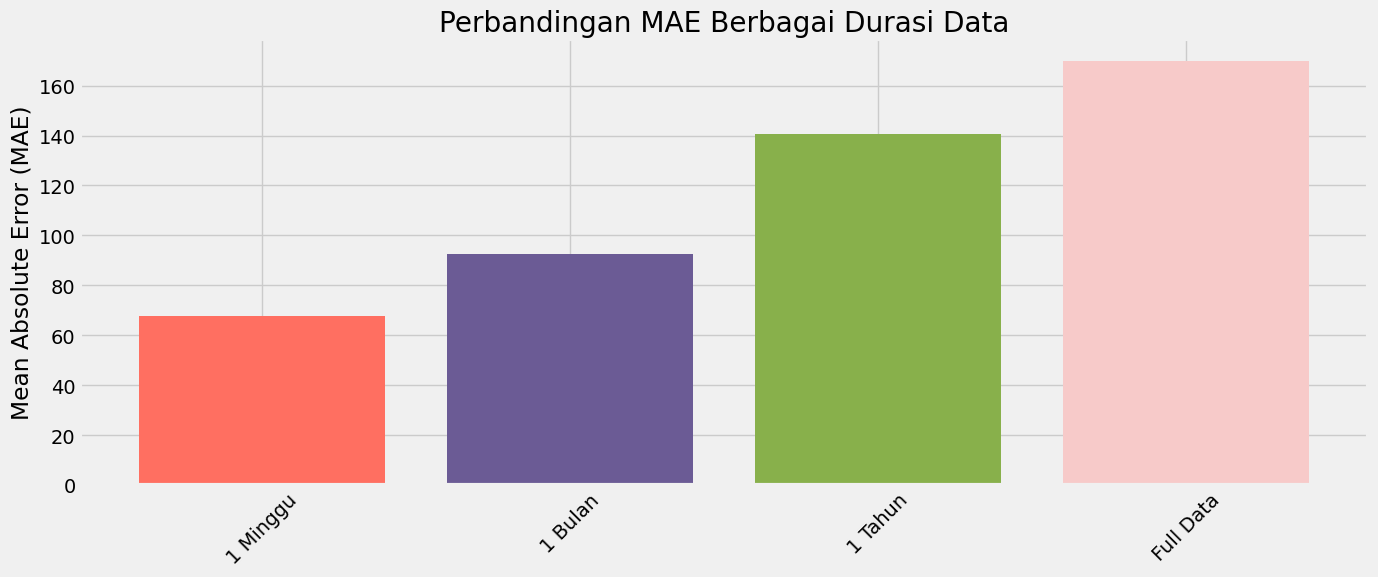

In [22]:
# %% [markdown]
# ## 5. Visualisasi Hasil
# Plot perbandingan MAE
plt.figure(figsize=(14,6))
mae_values = [results[d]['mae'] for d in results]
plt.bar(results.keys(), mae_values, color=['#FF6F61','#6B5B95','#88B04B','#F7CAC9'])
plt.title('Perbandingan MAE Berbagai Durasi Data')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

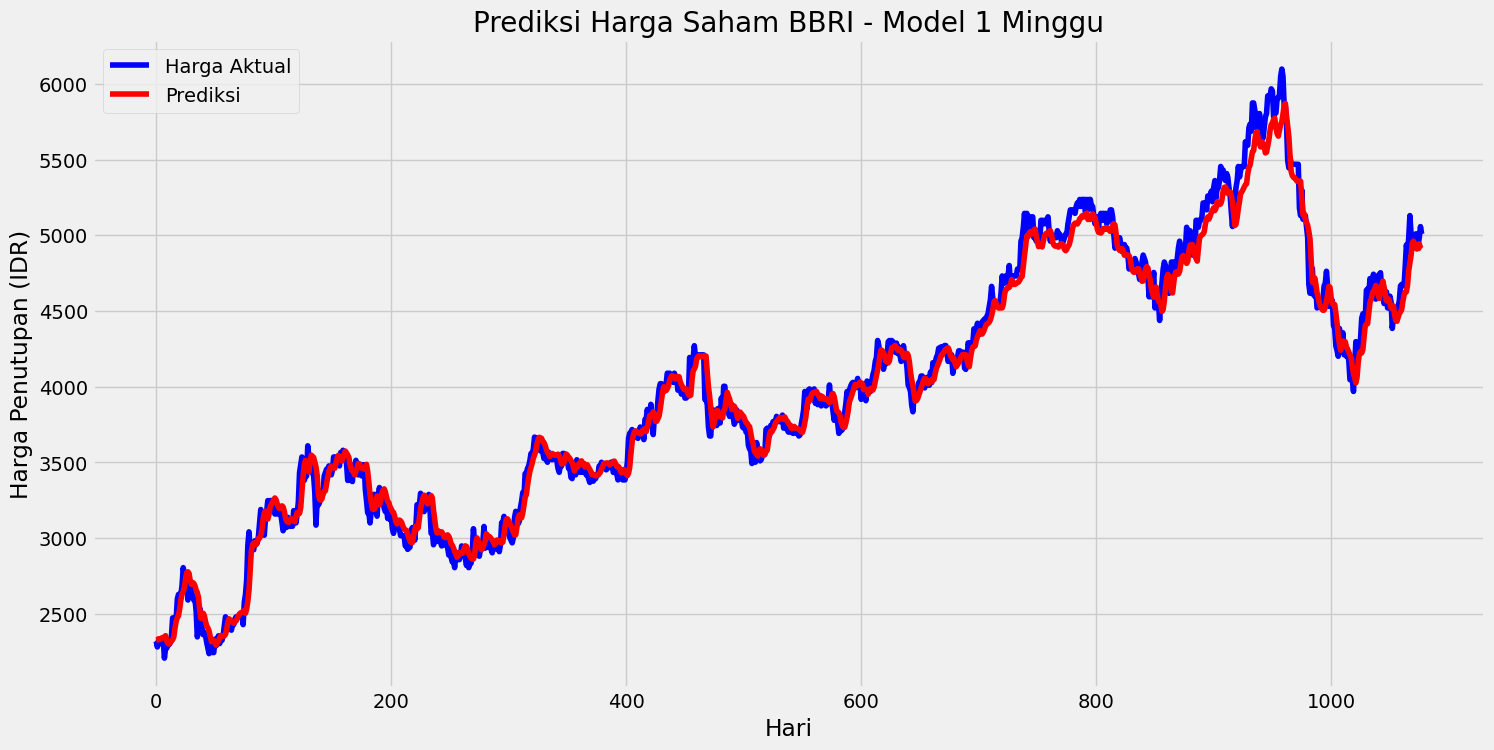

In [23]:
# Plot prediksi vs aktual untuk model terbaik
best_model = min(results, key=lambda x: results[x]['mae'])
predictions = results[best_model]['predictions']

plt.figure(figsize=(16,8))
actual = scaler.inverse_transform(scaled_data[-len(predictions):])
plt.plot(actual, color='blue', label='Harga Aktual')
plt.plot(predictions, color='red', label='Prediksi')
plt.title(f'Prediksi Harga Saham BBRI - Model {best_model}')
plt.xlabel('Hari')
plt.ylabel('Harga Penutupan (IDR)')
plt.legend()
plt.show()

In [24]:
# %% [markdown]
# ## 6. Hasil Evaluasi
print("\nHasil Evaluasi Model:")
print("-----------------------")
for model_name, res in results.items():
    print(f"{model_name}:")
    print(f"- MAE: {res['mae']:.2f}")
    print(f"- Architecture: {res['model'].summary()}")
    print("="*50)


Hasil Evaluasi Model:
-----------------------
1 Minggu:
- MAE: 67.54
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
- Architecture: None
1 Bulan:
- MAE: 92.73
Model: "sequential_1"
_______________